In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pdb
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import time
import tracemalloc

# Exact GP Solver 

In [2]:
# Step 1: Define the 2D RBF Kernel for Gaussian Process
class RBFKernel2D(nn.Module):
    def __init__(self, init_lengthscale=1.0, init_variance=1.0):
        super(RBFKernel2D, self).__init__()
        self.lengthscale = torch.nn.Parameter(torch.tensor(init_lengthscale))
        self.variance = torch.nn.Parameter(torch.tensor(init_variance))

    def forward(self, X1, X2):
        """
        Compute the RBF kernel between two sets of 2D inputs.
        :param X1: Tensor of shape [N1, 2] for 2D points.
        :param X2: Tensor of shape [N2, 2] for 2D points.
        :return: Kernel matrix of shape [N1, N2].
        """
        diff = X1 - X2  # Shape: (N1, N2, 2)
        dist_sq = diff.pow(2).sum(-1)  # Sum over the last dimension (for 2D)
        return (self.variance**2) * torch.exp(-0.5 * dist_sq / (self.lengthscale**2))

# Step 2: PDE and Boundary Operators for 2D
class PDEBoundaryOperators2D(torch.nn.Module):
    def __init__(self, kernel):
        super(PDEBoundaryOperators2D, self).__init__()
        self.kernel = kernel
        self.hess_diag_fnx2 = lambda x1,x2: torch.diag(torch.func.hessian(self.kernel, argnums=1)(x1,x2))
        self.grad_fnx2 =lambda x1,x2: torch.vmap(torch.vmap(torch.func.grad(kernel, argnums=1), in_dims=(0, 0)), in_dims=(0, 0))(x1, x2)
        self.hess_fnx2 = lambda x1,x2: torch.vmap(torch.vmap(self.hess_diag_fnx2, in_dims=(0, 0)), in_dims=(0, 0))(x1, x2)
        self.grad_fnx1 =lambda x1,x2: torch.vmap(torch.vmap(torch.func.grad(kernel, argnums=0), in_dims=(0, 0)), in_dims=(0, 0))(x1, x2)
        self.hess_diag_fnx1 = lambda x1,x2: torch.diag(torch.func.hessian(self.kernel, argnums=0)(x1,x2))
        self.hess_fnx1 = lambda x1,x2: torch.vmap(torch.vmap(self.hess_diag_fnx1, in_dims=(0, 0)), in_dims=(0, 0))(x1, x2)

    def apply_pde_operator(self, X1, X2):
        """
        Apply the PDE operator L to X1 and L^T to X2 in 2D.
        Compute second derivatives (Hessian) in both x and y directions.
        """
        X1_expand = X1.unsqueeze(1).repeat(1, X2.size(0),1).requires_grad_(True)
        X2_expand = X2.unsqueeze(0).repeat(X1.size(0), 1,1).requires_grad_(True)
        # K = self.kernel(X1_expand, X2_expand)

        return self.operator_lx1lx2(X1_expand, X2_expand).detach()

    def apply_lb_operator(self, X1, Xd,Xn):
        """
        Apply the PDE operator L to X1 and boundary operator B to Xb in 2D.
        """
        X1d_expand = X1.unsqueeze(1).repeat(1, Xd.size(0),1)
        Xd_expand = Xd.unsqueeze(0).repeat(X1.size(0), 1,1)
        hessian_K_x1 = self.hess_fnx1(X1d_expand, Xd_expand)
        grad_K_x1 = self.grad_fnx1(X1d_expand, Xd_expand)
        K_xb_dir = grad_K_x1[:, :, 1] - 0.01*hessian_K_x1[:, :, 0]

        X1n_expand = X1.unsqueeze(1).repeat(1, Xn.size(0),1)
        Xn_expand = Xn.unsqueeze(0).repeat(X1.size(0), 1,1)
        grad_lb = lambda x1,x2: torch.func.grad(self.hessgrad_funcx1, argnums=1)(x1,x2)
        K_xb_neu = torch.vmap(torch.vmap(grad_lb, in_dims=(0, 0)), in_dims=(0, 0))(X1n_expand, Xn_expand)[:,:,1]
        # Boundary condition: Dirichlet (use kernel directly)

        return torch.cat((K_xb_dir, K_xb_neu),dim=1).detach()

    def apply_boundary_operator(self, Xd, Xd_clone, Xn, Xn_clone):
        """
        Apply boundary operator B in 2D for boundary points.
        """
        Xd_expand = Xd.unsqueeze(1).repeat(1, Xd_clone.size(0),1)
        Xdc_expand = Xd_clone.unsqueeze(0).repeat(Xd.size(0), 1,1)
        K_dir = self.kernel(Xd_expand, Xdc_expand)
        Xn_expand = Xn.unsqueeze(1).repeat(1, Xn_clone.size(0),1)
        Xnc_expand = Xn_clone.unsqueeze(0).repeat(Xn.size(0), 1,1)
        K_neu = self.operator_gradx1x2(Xn_expand, Xnc_expand)

        Xdn_expand = Xd.unsqueeze(1).repeat(1, Xn.size(0),1)
        Xdnc_expand = Xn.unsqueeze(0).repeat(Xd.size(0), 1,1)
        K_dn = self.grad_fnx2(Xdn_expand, Xdnc_expand)[:,:,1]
        # Dirichlet boundary condition: Use the kernel directly
        return torch.cat((torch.cat((K_dir,K_dn),dim=1), torch.cat((K_dn.T,K_neu),dim=1)),dim=0).detach()

    def operator_lx2(self, X1, X2):
        hessian_K_x2 = self.hess_fnx2(X1, X2)
        grad_K_x2 = self.grad_fnx2(X1, X2)
        return -0.01*hessian_K_x2[:, :, 0] + grad_K_x2[:, :, 1]

    def operator_gradx1x2(self, X1, X2):
        grad_op = lambda x1,x2: torch.func.grad(self.kernel, argnums=1)(x1,x2)[1]
        grad_op2 = lambda x1,x2: torch.func.grad(grad_op, argnums=0)(x1,x2)
        return torch.vmap(torch.vmap(grad_op2, in_dims=(0, 0)), in_dims=(0, 0))(X1, X2)[:,:,1]

    def operator_lx1lx2(self, X1, X2):
        hess_diag_lx1lx2 = lambda x1,x2: torch.diag(torch.func.hessian(self.hessgrad_funcx2, argnums=0)(x1,x2))
        hess = torch.vmap(torch.vmap(hess_diag_lx1lx2, in_dims=(0, 0)), in_dims=(0, 0))(X1, X2)
        grad_op = lambda x1,x2: torch.func.grad(self.hessgrad_funcx2, argnums=0)(x1,x2)
        grad = torch.vmap(torch.vmap(grad_op, in_dims=(0, 0)), in_dims=(0, 0))(X1, X2)
        return grad[:,:,1] - 0.01*hess[:,:,0]

    def hessgrad_funcx2(self, X1, X2):
        grad_op = torch.func.grad(self.kernel, argnums=1)(X1,X2)
        hess_op = self.hess_diag_fnx2(X1, X2)
        return grad_op[1] - 0.01*hess_op[0]

    def hessgrad_funcx1(self, X1, X2):
        grad_op = torch.func.grad(self.kernel, argnums=0)(X1,X2)
        hess_op = self.hess_diag_fnx1(X1, X2)
        return grad_op[1] - 0.01*hess_op[0]
# Step 3: Posterior Mean and Covariance with Operators (2D version)
class PosteriorSolver2D(nn.Module):
    def __init__(self, kernel, operators, noise_variance=1e-4):
        super(PosteriorSolver2D, self).__init__()
        self.kernel = kernel
        self.operators = operators
        self.noise_variance = noise_variance

    def compute_covariance_matrix(self, Xi, Xd,Xn):
        """
        Construct the covariance matrix C in 2D.
        """
        Xi_clone = Xi.clone().detach()
        Xd_clone = Xd.clone().detach()
        Xn_clone = Xn.clone().detach()

        # Apply the PDE operator to interior points
        C_ii = self.operators.apply_pde_operator(Xi, Xi_clone)
        # Apply the boundary operator for interactions
        C_ib_dirichlet = self.operators.apply_lb_operator(Xi, Xd,Xn)
        C_bb_dirichlet = self.operators.apply_boundary_operator(Xd, Xd_clone, Xn, Xn_clone)

        # Combine into the full covariance matrix
        C_full = torch.cat([torch.cat([C_ii, C_ib_dirichlet], dim=1),
                            torch.cat([C_ib_dirichlet.T, C_bb_dirichlet], dim=1)], dim=0)

        return C_full

    def compute_covariance_vector(self, x, Xi, Xd,Xn):
        """
        Compute the covariance vector c(x) for a 2D point x.
        """
        x_expand = x.unsqueeze(1).repeat(1, Xi.size(0),1).requires_grad_(True)
        xd_expand = x.unsqueeze(1).repeat(1,Xd.size(0),1)
        Xi_expand = Xi.unsqueeze(0).repeat(x.size(0), 1,1).requires_grad_(True)
        Xd_expand = Xd.unsqueeze(0).repeat(x.size(0), 1,1)
        Xn_expand = Xn.unsqueeze(0).repeat(x.size(0), 1,1).requires_grad_(True)
        xn_expand = x.unsqueeze(1).repeat(1,Xn.size(0),1)
        # Apply the PDE operator to the point x
        L_K_x= self.operators.operator_lx2(x_expand, Xi_expand)

        B_K_x_dirichlet = self.kernel(xd_expand, Xd_expand)

        B_K_x_neumann = self.operators.grad_fnx2(xn_expand, Xn_expand)[:,:,1]

        return torch.cat((L_K_x.detach(), B_K_x_dirichlet.detach(),B_K_x_neumann.detach()), dim=1)

    def posterior_mean(self, x, Xi, Xd,Xn, C_inv, y):
        """
        Compute the posterior mean in 2D at point x.
        """
        c_x = self.compute_covariance_vector(x, Xi, Xd,Xn)
        return c_x @ C_inv @ y

    def posterior_mean_sdd(self, x, Xi, Xd, Xn, A_approx):
        """
        Compute the posterior mean in 2D at point x using SDD approximation.
        """
        c_x = self.compute_covariance_vector(x, Xi, Xd, Xn)
        return c_x @ A_approx

    def posterior_covariance(self, x, x_prime, Xi, Xd,Xn, C_inv):
        """
        Compute the posterior covariance in 2D between x and x_prime.
        """
        c_x = self.compute_covariance_vector(x, Xi, Xd,Xn)
        # c_x_prime = self.compute_covariance_vector(x_prime, Xi, Xb)

        x_expand = x.unsqueeze(1).repeat(1, x_prime.size(0),1)
        x_prime_expand = x_prime.unsqueeze(0).repeat(x.size(0), 1,1)
        base_cov = self.kernel(x_expand, x_prime_expand)
        c_x_cinv_cxprime = c_x @ C_inv @ c_x.T
        posterior_cov = base_cov - c_x_cinv_cxprime
        return posterior_cov#torch.clamp(posterior_cov, min=1e-10)

    def posterior_covariance_sdd(self, x, x_prime, cov_vec, A_approx):
        """
        Compute the posterior covariance in 2D between x and x_prime using SDD approximation.
        """
        x_expand = x.unsqueeze(1).repeat(1, x_prime.size(0),1)
        x_prime_expand = x_prime.unsqueeze(0).repeat(x.size(0), 1,1)
        base_cov = self.kernel(x_expand, x_prime_expand)
        c_x_cinv_cxprime = cov_vec @ A_approx
        posterior_cov = base_cov - c_x_cinv_cxprime
        return posterior_cov

def generate_square_domain_data(n_samples_per_side=10):
    """
    Generate data sampled uniformly within a square domain (0, 1) x (0, 1).

    :param n_samples_per_side: Number of samples per side of the square (including boundaries).
    :return: Xi (interior points), Xb (boundary points), f_Xi (interior values),
             g_Xd (Dirichlet boundary values), g_Xn (Neumann boundary values)
    """
    # Generate points uniformly in the square domain [0, 1] x [0, 1]
    x = torch.linspace(0, 1, n_samples_per_side)
    y = torch.linspace(0, 1, n_samples_per_side)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    points = torch.stack([X.flatten(), Y.flatten()], dim=1)

    # Separate interior points and boundary points
    interior_mask = (points[:, 0] > 0) & (points[:, 0] < 1) & (points[:, 1] > 0) & (points[:, 1] < 1)
    Xi = points[interior_mask]  # Interior points

    # Identify boundary points: bottom, left, right, and top
    bottom_boundary_mask = (points[:, 1] == 0)
    left_boundary_mask = (points[:, 0] == 0)
    right_boundary_mask = (points[:, 0] == 1)
    top_boundary_mask = (points[:, 1] == 1)

    # Combine boundary masks to get all boundary points
    boundary_mask = bottom_boundary_mask | left_boundary_mask | right_boundary_mask | top_boundary_mask
    Xb = points[boundary_mask]

    # Separate boundary points for Dirichlet (left, right, bottom) and Neumann (top)
    Xd = torch.cat((points[bottom_boundary_mask][1:-1], points[left_boundary_mask][:-1], points[right_boundary_mask][:-1]),dim=0)
    Xn = points[top_boundary_mask]

    # Compute the source term (f(Xi)) for the Poisson equation at the interior points
    f_Xi = torch.zeros(Xi.shape[0])  # For Poisson equation: f(x1, x2) = -1
    # Compute Dirichlet boundary values
    # Bottom boundary has Gaussian pulse as initial condition
    x0 = 0.5  # Center of the Gaussian pulse
    sigma = 0.15  # Width of the Gaussian pulse
    g_Xd_bottom = torch.sin(torch.pi*points[bottom_boundary_mask][1:-1][:, 0])

    # Left and right boundaries are 0
    g_Xd_left_right = torch.zeros(left_boundary_mask.sum()-1 + right_boundary_mask.sum()-1)

    # Concatenate Dirichlet boundary values
    g_Xd = torch.cat([g_Xd_bottom, g_Xd_left_right], dim=0)

    # Neumann boundary values are 0 (top boundary)
    g_Xn = torch.zeros(Xn.shape[0])

    return Xi.to(torch.float64), Xd.to(torch.float64),Xn.to(torch.float64), f_Xi.to(torch.float64), g_Xd.to(torch.float64), g_Xn.to(torch.float64)

In [3]:
# Parameters
L_x = 1.0         # Length of spatial domain
L_t = 1.0         # Length of pseudo-time domain
N_x = 10           # Number of spatial points
N_t = 10           # Number of pseudo-time points
alpha = 0.01      # Thermal diffusivity

# Grid spacing
dx = L_x / (N_x - 1)
dt = L_t / (N_t - 1)

# Spatial grid and initial Gaussian pulse
x = np.linspace(0, L_x, N_x)
x0 = L_x / 2       # Center of the Gaussian pulse
sigma = 0.15        # Width of the Gaussian pulse

# Initial condition: Gaussian pulse
u_initial = np.sin(np.pi*x)

# Helper function to map 2D indices (i, j) to 1D index
def index(i, j):
    return i + j * N_x

# Number of unknowns
num_points = N_x * N_t

# Sparse matrix A and right-hand side vector b
A = lil_matrix((num_points, num_points))
b = np.zeros(num_points)

# Construct the matrix A and vector b
for j in range(N_t):
    for i in range(N_x):
        k = index(i, j)  # Linear index for the current grid point

        # Boundary conditions
        if i == 0 or i == N_x - 1:  # Spatial boundaries (Dirichlet)
            A[k, k] = 1
            b[k] = 0  # Fixed temperature at boundaries
        elif j == 0:  # Initial pseudo-time boundary with Gaussian pulse
            A[k, k] = 1
            b[k] = u_initial[i]  # Set Gaussian pulse as initial condition
        elif j == N_t - 1:  # Neumann boundary at end of pseudo-time
            A[k, k] = 1
            A[k, index(i, j - 1)] = -1  # Zero gradient at end of pseudo-time
            b[k] = 0
        else:
            # Interior points
            A[k, k] = 1 + 2 * alpha * dt / dx**2
            A[k, index(i - 1, j)] = -alpha * dt / dx**2
            A[k, index(i + 1, j)] = -alpha * dt / dx**2
            A[k, index(i, j - 1)] = -1

# Solve the linear system
u = spsolve(A.tocsr(), b)

# Reshape the solution to a 2D grid
u = u.reshape((N_t, N_x))
u1 = u.copy()
# Plot the result
x = np.linspace(0, L_x, N_x)
t = np.linspace(0, L_t, N_t)
X, T = np.meshgrid(x, t)
# Flatten the arrays
X_flat = X.flatten()
T_flat = T.flatten()
u_flat = u.flatten()

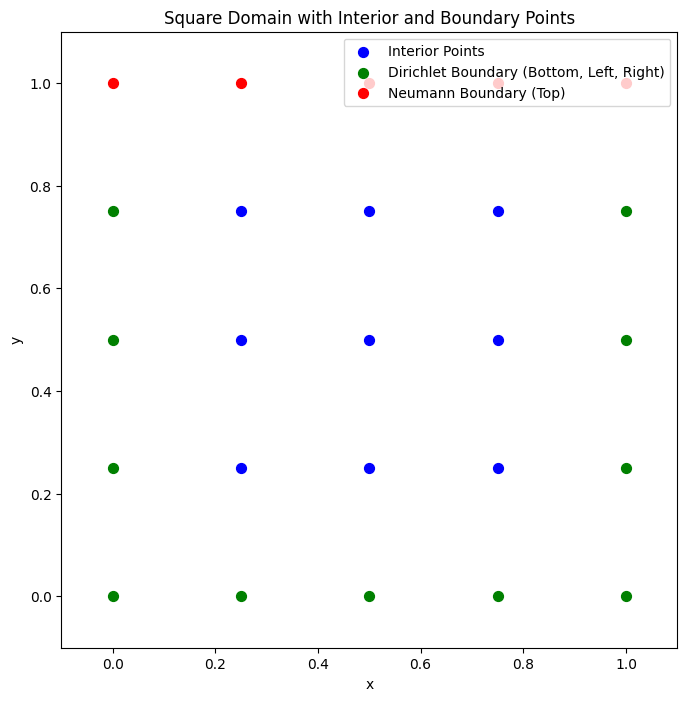

In [4]:
# Example usage
Xi, Xd,Xn, f_Xi, g_Xd, g_Xn = generate_square_domain_data(n_samples_per_side=5)

# Plotting the interior and boundary points
plt.figure(figsize=(8, 8))
plt.scatter(Xi[:, 0], Xi[:, 1], color='blue', label='Interior Points', s=50)
plt.scatter(Xd[:, 0], Xd[:, 1], color='green', label='Dirichlet Boundary (Bottom, Left, Right)', s=50)
plt.scatter(Xn[:, 0], Xn[:, 1], color='red', label='Neumann Boundary (Top)', s=50)

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Square Domain with Interior and Boundary Points')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [5]:
kernel = RBFKernel2D(init_lengthscale=0.6,init_variance =0.02)
operators = PDEBoundaryOperators2D(kernel=kernel)
solver = PosteriorSolver2D(kernel=kernel, operators=operators)

# Combine interior and boundary observations
y_obs = torch.cat((f_Xi, g_Xd,g_Xn), dim=0)

X_1,X_2,X_3,_,_,_ = generate_square_domain_data(n_samples_per_side=10)
X_test = torch.cat((X_1,X_2,X_3),dim=0)

# # Full covariance matrix and inverse for the observations
C_full = solver.compute_covariance_matrix(Xi, Xd,Xn)
C_inv = torch.inverse(C_full + 1e-6 * torch.eye(C_full.shape[0]))  # Add jitter for stability


# # Make predictions at a test point
# x_test = torch.tensor([[0.5, 0.5]], requires_grad=True)
posterior_mean = solver.posterior_mean(X_test, Xi, Xd,Xn, C_inv, y_obs)
posterior_cov_full = solver.posterior_covariance(X_test, X_test.detach().clone(), Xi, Xd,Xn, C_inv)
posterior_cov = torch.sqrt(torch.diag(posterior_cov_full)).reshape(-1,1)
print(torch.sum(torch.isnan(posterior_cov)))

tensor(0)


# SDD inference

In [6]:
torch.manual_seed(1)
# SDD algorithm parameters
du = 1            # Output dimension
input_dim = 1     # Input dimension
sigma_n = 0       # Likelihood variance
T = 1000          # Number of steps
B = 20           # Batch size
beta = 5          # Step size
rho = 0.9         # Momentum parameter
r = 0.9           # Averaging parameter
num_epochs = 4000

# Initialize parameters
def train_SDD(N,du,input_dim,sigma_n, T,B,beta,rho,r,num_epochs,C,y):
    print(f"Training SDD with N={N}, batch_size={B}")
    
    # Start memory and time tracking
    tracemalloc.start()
    start_time = time.time()
    
    A_t = torch.zeros(N, du,dtype=torch.float64)       # Parameter A_t
    V_t = torch.zeros(N, du,dtype=torch.float64)        # Velocity V_t
    A_bar_t = torch.zeros(N, du,dtype=torch.float64)    # Averaged parameter A_bar_t
    K_full = (C + 1e-6 * torch.eye(C.shape[0]))
    
    for t in range(num_epochs):
        S = A_t + rho * V_t      # Shape: [N, du]

        # Sample random batch indices - ensure they're within bounds
        It = torch.randint(0, N, (min(B, N),))  # Use min(B, N) to avoid index errors

        # Initialize gradient G_t
        G_t = torch.zeros(N, du,dtype=torch.float64)

        # For each index i in the batch
        batch_size_actual = len(It)
        G_t[It] = (N / batch_size_actual)*K_full[It]@S - y[It]
        V_t = rho * V_t - beta * G_t                  # Update V_t

        # Update parameters A_t
        A_t += V_t

        # Iterative averaging of parameters
        A_bar_t = r * A_t + (1 - r) * A_bar_t

        #(Optional) Compute and print the loss every 100 steps
        if t % 1000 == 0 or t == num_epochs-1:
            # Compute the predictions
            pred = K_full @ A_t                  # Shape: [N, du]
            loss_term1 = 0.5 * torch.norm(y - pred) ** 2
            At_K_At = torch.sum(A_t * (K_full @ A_t))
            loss_term2 = (sigma_n / 2) * At_K_At
            L_t = loss_term1 + loss_term2
            
            # Get current memory usage
            current, peak = tracemalloc.get_traced_memory()
            elapsed_time = time.time() - start_time
            
            print(f"Step {t}, Loss: {L_t.item():.6e}, Time: {elapsed_time:.2f}s, Memory: {current/1024/1024:.2f}MB")
    
    # Final memory and time measurement
    final_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    print(f"Training completed in {final_time:.2f}s, Peak memory: {peak/1024/1024:.2f}MB")
    
    A_approx = A_bar_t
    return A_approx


In [7]:
# Get actual data size
N = C_full.shape[0]  # Use actual size of covariance matrix
print(f"Actual data size N = {N}")

with torch.no_grad():
    C_full_jitter = C_full + 1e-6 * torch.eye(C_full.shape[0])
    A_approx = train_SDD(N,du,input_dim,sigma_n, T,B,beta,rho,r,num_epochs,C_full_jitter,y_obs.reshape(-1,1))

Actual data size N = 25
Training SDD with N=25, batch_size=20
Step 0, Loss: 9.970035e-01, Time: 0.00s, Memory: 0.00MB
Step 1000, Loss: 7.225593e-02, Time: 0.22s, Memory: 0.14MB
Step 2000, Loss: 4.498945e-02, Time: 0.36s, Memory: 0.14MB
Step 3000, Loss: 4.140959e-02, Time: 0.52s, Memory: 0.14MB
Step 3999, Loss: 4.047455e-02, Time: 0.67s, Memory: 0.14MB
Training completed in 0.67s, Peak memory: 0.15MB


In [8]:
torch.manual_seed(0)
with torch.no_grad():
    C_full_jitter = C_full + 1e-6 * torch.eye(C_full.shape[0])
    cov_vec = solver.compute_covariance_vector(X_test, Xi, Xd, Xn).detach()
    
    # Use actual data size for variance computation
    N_actual = C_full.shape[0]
    print(f"Computing variance with N_actual = {N_actual}, cov_vec.shape = {cov_vec.shape}")
    
    A_approx_var = train_SDD(N_actual,cov_vec.shape[0],input_dim,sigma_n, T,B,beta,rho,r,num_epochs,C_full_jitter,cov_vec.T)

Computing variance with N_actual = 25, cov_vec.shape = torch.Size([100, 25])
Training SDD with N=25, batch_size=20
Step 0, Loss: 7.133032e-05, Time: 0.00s, Memory: 0.14MB
Step 1000, Loss: 2.953794e-06, Time: 0.19s, Memory: 0.14MB
Step 2000, Loss: 2.952897e-06, Time: 0.38s, Memory: 0.14MB
Step 3000, Loss: 2.952267e-06, Time: 0.55s, Memory: 0.14MB
Step 3999, Loss: 2.952423e-06, Time: 0.71s, Memory: 0.15MB
Training completed in 0.71s, Peak memory: 0.15MB


In [9]:
posterior_mean_sdd = solver.posterior_mean_sdd(X_test, Xi, Xd, Xn, A_approx).detach()
posterior_cov_sdd = solver.posterior_covariance_sdd(X_test, X_test.clone(), cov_vec, A_approx_var).detach()
posterior_cov_sdd_sqrt = torch.sqrt(torch.diag(posterior_cov_sdd)).reshape(-1,1)
print(f"SDD predictions computed. NaN count: {torch.sum(torch.isnan(posterior_cov_sdd_sqrt))}")

SDD predictions computed. NaN count: 0


In [10]:
C_full.dtype

torch.float64

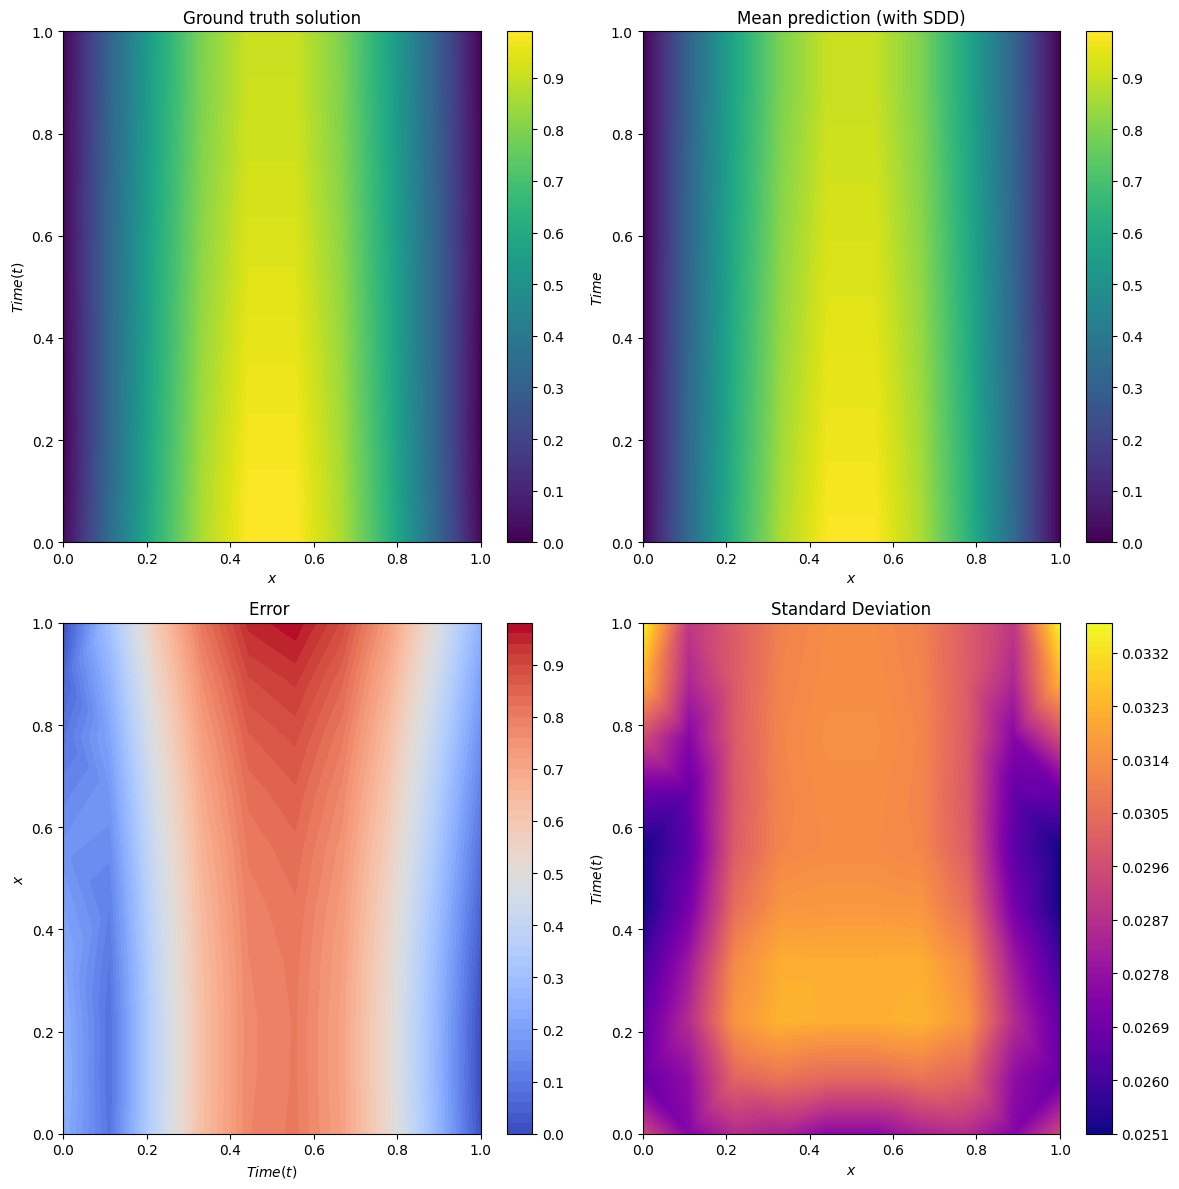

In [12]:
# Assuming X_test and posterior_mean are already defined
# X_test.shape = (60, 2), posterior_mean.shape = (60, 1)

# Detach the tensors from the computation graph if requires_grad=True
x1 = X_test[:, 0].detach().numpy()  # Extract the x1 (first column)
x2 = X_test[:, 1].detach().numpy()  # Extract the x2 (second column)
posterior_mean_np = posterior_mean.detach().numpy().reshape(-1)  # Flatten the posterior mean
posterior_cov_np = posterior_cov.detach().numpy().reshape(-1)  # Flatten the posterior covariance

# Create a grid of points for contour plots
# Step 1: Compute the actual solution u(x1, x2) = (1 - x1^2 - x2^2) / 4
actual_solution = (1 - x1**2 - x2**2) / 4

# Step 2: Compute the error between the posterior mean and actual solution
error = np.abs(posterior_mean_np - actual_solution)

# Step 3: Compute the posterior covariance
# Assuming posterior_covariance is a (60, 60) matrix from GP model
# posterior_covariance = ... (you need to compute this with your GP model)
# For this example, let's assume we have the posterior covariance matrix

# Step 4: (Optional) Compute the posterior covariance using SDD approximation if needed
# posterior_covariance_sdd = ... (compute this using the new method in your class)

# Step 5: Create subplots for posterior mean, actual solution, error, and posterior covariance
fig, axes = plt.subplots(2, 2, figsize=(12, 12))  # Create 4 subplots

# Plot the posterior mean
contour_actual = axes[0, 1].tricontourf(X_flat, T_flat, u_flat, levels=100, cmap='viridis')
fig.colorbar(contour_actual, ax=axes[0, 0])
axes[0, 0].set_title('Ground truth solution')
axes[0, 0].set_xlabel('$x$')
axes[0, 0].set_ylabel('$Time (t)$')

#Plot the actual solution
contour_posterior = axes[0, 0].tricontourf(x1, x2, posterior_mean_np, levels=100)
fig.colorbar(contour_actual, ax=axes[0, 1])
axes[0, 1].set_title('Mean prediction (with SDD)')
axes[0, 1].set_xlabel('$x$')
axes[0, 1].set_ylabel('$Time$')

# Plot the error (posterior mean - actual solution)
contour_error = axes[1, 0].tricontourf(x1, x2, error, levels=50, cmap='coolwarm')
fig.colorbar(contour_error, ax=axes[1, 0])
axes[1, 0].set_title('Error ')
axes[1, 0].set_xlabel('$ Time (t)$')
axes[1, 0].set_ylabel('$x$')

#Plot the posterior variance (diagonal of posterior covariance) as a contour plot
contour_variance = axes[1, 1].tricontourf(x1, x2, np.sqrt(posterior_cov_np),levels=100,cmap='plasma')
fig.colorbar(contour_variance, ax=axes[1, 1])
axes[1, 1].set_title('Standard Deviation')
axes[1, 1].set_xlabel('$x$')
axes[1, 1].set_ylabel('$Time (t)$')

# Adjust layout to prevent overlap
plt.tight_layout()




plt.show()

In [26]:
# # Define the log-likelihood function
# def log_likelihood(kernel, Xi, Xd, Xn, y_obs):
#     # Compute the full covariance matrix using the current kernel parameters
#     solver = PosteriorSolver2D(kernel=kernel, operators=PDEBoundaryOperators2D(kernel=kernel))
#     C_full = solver.compute_covariance_matrix(Xi.requires_grad_(True), Xd.requires_grad_(True), Xn.requires_grad_(True))

#     # Add jitter for numerical stability
#     C_full += 1e-6 * torch.eye(C_full.shape[0])

#     # Compute the inverse of the covariance matrix
#     C_inv = torch.inverse(C_full)

#     # Compute log determinant of the covariance matrix
#     log_det_C = torch.logdet(C_full)

#     # Compute the log-likelihood
#     n = y_obs.shape[0]
#     ll = -0.5 * y_obs.T @ C_inv @ y_obs - 0.5 * log_det_C

#     return ll

# # Initialize kernel parameters
# kernel = RBFKernel2D(init_lengthscale=0.1, init_variance=0.003)

# # Define the optimizer for the kernel parameters
# optimizer = torch.optim.Adam([kernel.lengthscale, kernel.variance], lr=0.1)

# # Maximum Likelihood Estimation Loop
# n_iters = 100  # Number of iterations
# for i in range(n_iters):
#     optimizer.zero_grad()

#     # Compute the negative log-likelihood (since we want to maximize the likelihood)
#     ll = log_likelihood(kernel, Xi, Xd, Xn, y_obs)
#     loss = -ll  # We minimize the negative log-likelihood

#     # Backpropagate to compute gradients
#     loss.backward()

#     # Update the kernel parameters
#     optimizer.step()

#     # Print progress
#     if i % 10 == 0:
#         print(f"Iteration {i}: Lengthscale = {kernel.lengthscale.item()}, Variance = {kernel.variance.item()}, Log-Likelihood = {ll.item()}")

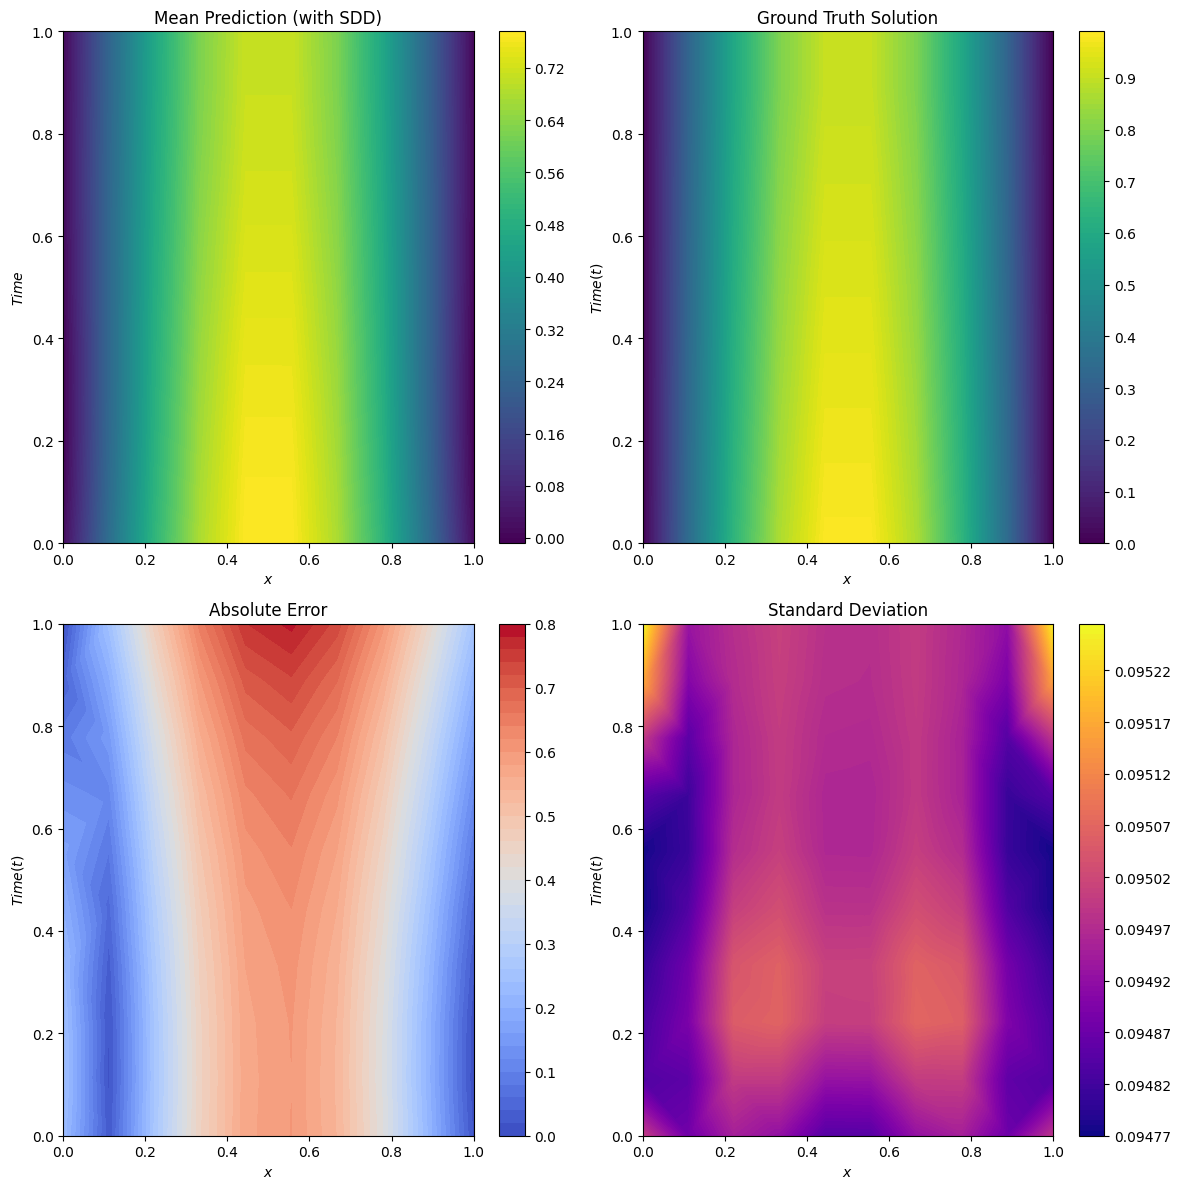

In [27]:
# Assuming X_test and posterior_mean are already defined
# X_test.shape = (60, 2), posterior_mean.shape = (60, 1)

# Detach the tensors from the computation graph if requires_grad=True
x1 = X_test[:, 0].detach().numpy()  # Extract the x1 (first column)
x2 = X_test[:, 1].detach().numpy()  # Extract the x2 (second column)
posterior_mean_np = posterior_mean_sdd.detach().numpy().reshape(-1)  # Use SDD posterior mean
posterior_cov_np = posterior_cov_sdd_sqrt.detach().numpy().reshape(-1)  # Use SDD posterior covariance

# Create a grid of points for contour plots
# Step 1: Compute the actual solution u(x1, x2) = (1 - x1^2 - x2^2) / 4
actual_solution = (1 - x1**2 - x2**2) / 4

# Step 2: Compute the error between the posterior mean and actual solution
error = np.abs(posterior_mean_np - actual_solution)

# Step 3: Compute the posterior covariance

# Step 5: Create subplots for posterior mean, actual solution, error, and posterior covariance
fig, axes = plt.subplots(2, 2, figsize=(12, 12))  # Create 4 subplots

# Plot the SDD posterior mean
contour_posterior = axes[0, 0].tricontourf(x1, x2, posterior_mean_np, levels=100, cmap='viridis')
fig.colorbar(contour_posterior, ax=axes[0, 0])
axes[0, 0].set_title('Mean Prediction (with SDD)')
axes[0, 0].set_xlabel('$x$')
axes[0, 0].set_ylabel('$Time$')

# Plot the ground truth solution
contour_actual = axes[0, 1].tricontourf(X_flat, T_flat, u_flat, levels=100, cmap='viridis')
fig.colorbar(contour_actual, ax=axes[0, 1])
axes[0, 1].set_title('Ground Truth Solution')
axes[0, 1].set_xlabel('$x$')
axes[0, 1].set_ylabel('$Time (t)$')

# Plot the error (posterior mean - actual solution)
contour_error = axes[1, 0].tricontourf(x1, x2, error, levels=50, cmap='coolwarm')
fig.colorbar(contour_error, ax=axes[1, 0])
axes[1, 0].set_title('Absolute Error')
axes[1, 0].set_xlabel('$x$')
axes[1, 0].set_ylabel('$Time (t)$')

# Plot the posterior variance (diagonal of posterior covariance) as a contour plot
contour_variance = axes[1, 1].tricontourf(x1, x2, np.sqrt(posterior_cov_np), levels=100, cmap='plasma')
fig.colorbar(contour_variance, ax=axes[1, 1])
axes[1, 1].set_title('Standard Deviation')
axes[1, 1].set_xlabel('$x$')
axes[1, 1].set_ylabel('$Time (t)$')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()